In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from tqdm import tqdm
import os
from PIL import Image

In [2]:
def getNeighborsTemperature(grid, point, boundaryTemp):
    neighbors = []
    for i in range(-1, 2):
        try:
            if abs(i) != 0:
                neighbors.append(grid[point + i][0])
        except IndexError:
            neighbors.append(boundaryTemp)

    return neighbors


def getNeighborsTemperature_left_material_boundary(grid, point, k):
    neighbors = []
    for i in range(-1, 2):
        # left neighbor: same material
        if i == -1:
            neighbors.append(grid[point + i][0])
        # right neighbor: new material
        elif i == 1:
            temperature = ((k - 1) / (k + 1)) * grid[point][0] + (2 / (k + 1)) * grid[point + i][0]
            neighbors.append(temperature)

    return neighbors


def getNeighborsTemperature_right_material_boundary(grid, point, k):
    neighbors = []
    for i in range(-1, 2):
        # left neighbor: new material
        if i == -1:
            temperature = (2 * k / (k + 1)) * grid[point - 1][0] - ((k - 1) / (k + 1)) * grid[point][0]
            neighbors.append(temperature)
        
        # right neighbor: same material
        elif i == 1:
            neighbors.append(grid[point + i][0])

    return neighbors


def calculateHeat(cellTemp, neighborTemps, gamma):
    cellTemp = cellTemp + gamma*((neighborTemps[0] -2*cellTemp + neighborTemps[1]))
    return np.float64(cellTemp)


def heatTransfer(grid, boundaryTemp, material_index,k):
    #print("LEERZEICHEN")
    for i in range(0,len(grid)):
        
        # Material 1
        if abs(i-1) < material_index:
            neighbors = getNeighborsTemperature(grid,i, boundaryTemp)
            grid[i][0] = calculateHeat(grid[i][0], neighbors, grid[i][1])
            #print(grid[:,:,1][i])
        
        # Boundary of Material 1
        elif abs(i) == material_index:
            neighbors = getNeighborsTemperature_left_material_boundary(grid,i, k)
            grid[i][0] = calculateHeat(grid[i][0], neighbors, grid[i][1])
        
        # Boundary of Material 2
        elif abs(i) == (material_index + 1):
            neighbors = getNeighborsTemperature_right_material_boundary(grid,i,k)
            grid[i][0] = calculateHeat(grid[i][0], neighbors, grid[i][1])
        
        # Material 2
        elif abs(i)>(material_index+1):
            neighbors = getNeighborsTemperature(grid,i, boundaryTemp)
            grid[i][0] = calculateHeat(grid[i][0], neighbors, grid[i][1])
            
    return grid


def calculateAverageTemperatureWithinCircle(grid, resolution1):
    # Extract the temperature values from the grid
    temperatures = []
    for i in range(resolution1):
        temperatures.append(grid[i][0])

    # Calculate the average temperature within the circle
    average_temperature = np.sum(temperatures)/resolution1
    
    return average_temperature



def makeGif(frames,name,timeStep,minTemp,maxTemp, frames_name):
        counter=0
        y_aspect = 1
        images = []
        
        for i in tqdm(range(0,len(frames))):
                x_values = np.arange(0, 37)
                data = np.array([frames[i]])
                plt.figure()
                plt.title(f"Temperature at t = {counter*timeStep:.3f} unit time")
                plt.imshow(data, extent=[min(x_values)-0.5, max(x_values)+0.5, 0, 1], aspect='auto', cmap="inferno", vmin=minTemp, vmax=maxTemp)
                plt.gca().set_aspect(y_aspect, adjustable='box')
                plt.colorbar(label='Temperature')
                plt.xlabel('Nodes')
                plt.yticks([])
                
                plt.savefig("frames/" + frames_name + "/"+str(counter)+ '_'+ frames_name + ".png")
                images.append(imageio.imread("frames/" + frames_name + "/"+str(counter)+ '_'+ frames_name + ".png"))
                counter += 1
                plt.close()

        imageio.mimsave("gifs/"+name+ ".gif", images)
        
def makeGif_new(frames,name,timeStep,frames_name):
        counter=0
        images = []
        
        for i in tqdm(range(0,len(frames))):
                x_values = np.arange(0, 370)
                plt.figure()
                plt.title(f"Temperature at t = {counter*timeStep:.3f} unit time")
                plt.plot(x_values, frames[i])
                
                plt.xlabel('Nodes')
                plt.ylabel("Temperature in K")
                plt.yticks([])
                
                plt.savefig("frames/" + frames_name + "/"+str(counter)+ '_'+ frames_name + ".png")
                images.append(imageio.imread("frames/" + frames_name + "/"+str(counter)+ '_'+ frames_name + ".png"))
                counter += 1
                plt.close()

        imageio.mimsave("gifs/"+name+ ".gif", images)

In [13]:
# Arrays to store data
timeStep_array = []
average_temperatures_in_circle_TaTe2 = []
temp_array = []
frames_name = "gold_scan"
gif_name = "gold_scan"
frames = []

# Make 1D grid
resolution1 = 70
resolution2 = 300
resolution = resolution1 + resolution2
number_of_steps = 00000

# Constants
startingTemperature = 103.15  # Round about -170C°
boundaryTemp = 103.15
gamma1 = 0.0021
gamma2 = 0.25
k = 0.00441
material_index = 7
timeStep = 1.96 * 10**(-8)

####...Simulation...###
value_to_add = np.float64(492.2)

x1 = np.full(resolution, startingTemperature)

x2_material1 = np.full(resolution1, gamma1)
x2_material2 = np.full(resolution2, gamma2)

x2 = np.concatenate([x2_material1, x2_material2], axis=0)

gridX = np.column_stack((x1, x2))  # Use column_stack to create a 2D array

fullGridX = gridX.copy()

# Aktualisiere die Werte im Gitter entsprechend der Maske
fullGridX[:resolution1, 0] += value_to_add

frames = []
average_temperatures_in_circle = []
for t in tqdm(range(number_of_steps)):
    frames_small = []
    # Calculate the average temperature within the circle and append to the list
    average_temp = calculateAverageTemperatureWithinCircle(fullGridX, resolution1)
    temp_array.append(average_temp)
    
    fullGridX = heatTransfer(fullGridX.copy(), boundaryTemp, material_index, k)
    
    for i in range(len(fullGridX)):
        frames_small.append(fullGridX[i][0])
    frames.append(frames_small)

#Make Gif, saves as "simulation.gif"
#makeGif(frames,gif_name,timeStep,103.15,500, frames_name)

 10%|█         | 1010769/10000000 [25:19<3:45:15, 665.09it/s]


KeyboardInterrupt: 

In [ ]:
makeGif_new(frames,gif_name,timeStep, frames_name)

In [7]:
file_path = 'heating_array.txt'

np.savetxt(file_path,temp_array, delimiter=',', newline='\n', fmt='%f')

loaded_array= np.loadtxt(file_path, delimiter=',')
print(len(loaded_array))

500000


In [10]:
specific_point = timeStep*number_of_steps
step_size = timeStep
time_step_array =  np.arange(0, specific_point, step_size)
print(len(time_step_array))

500000


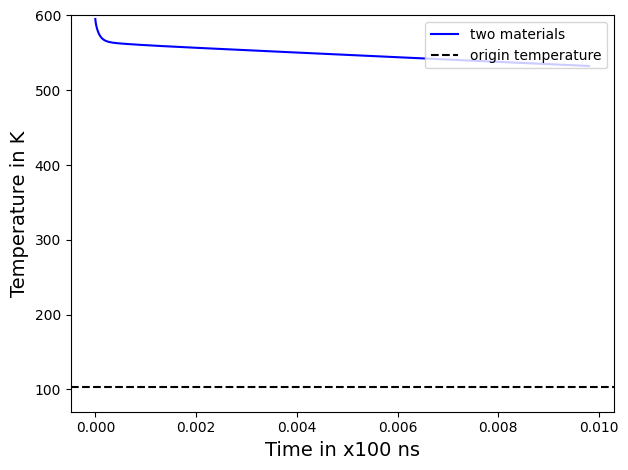

In [11]:
#Plot the Result
plt.minorticks_on
plt.xlabel(r'Time in x100 ns', fontsize="14")
plt.ylabel(r"Temperature in K", fontsize="14")

# Diameter

plt.plot(time_step_array, loaded_array, color= "blue", label = "two materials" )
plt.legend(loc="upper right")

# Show line where the CDW Spots arge gone
plt.axhline(y=103.15, color='black', linestyle='--', label='origin temperature')
plt.ylim(70, 600)
#plt.xlim(0.0001,0.0027)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()